In [60]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-sep-2021/train.csv
/kaggle/input/tabular-playground-series-sep-2021/test.csv
/kaggle/input/tabular-playground-series-sep-2021/sample_solution.csv


# **Prepare Data**

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from autogluon.tabular import TabularPredictor
warnings.filterwarnings("ignore")

In [109]:
train_df = pd.read_csv("/kaggle/input/tabular-playground-series-sep-2021/train.csv")
test_df = pd.read_csv("/kaggle/input/tabular-playground-series-sep-2021/test.csv")

# **Explore Data**

## **Data**

In [63]:
train_df.head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
0,0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,...,-12.2280,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.1,1.01770,1
1,1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,...,-56.7580,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.0,0.28359,0
2,2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,...,-5.7688,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.2,0.40690,1
3,3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,...,-34.8580,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.1,0.51486,1
4,4,0.11623,0.502900,-109.150,0.297910,0.34490,-0.40932,2538.90,65332.0,1.907200e+15,...,-13.6410,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,NaN,0.23049,1


In [64]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957919 entries, 0 to 957918
Columns: 120 entries, id to claim
dtypes: float64(118), int64(2)
memory usage: 877.0 MB


In [65]:
train_df.shape,test_df.shape

((957919, 120), (493474, 119))

In [66]:
train_df['claim'].value_counts()

claim
0    480404
1    477515
Name: count, dtype: int64

## **Missing Data**

In [110]:
def check_miss(df):
    total = df.isnull().sum()
    percent = (df.isnull().sum()/df.isnull().count()*100)
    tt = pd.concat([total,percent],axis = 1, keys = ['Total','Percent'])
    typ = []
    for i in df.columns:
        typ.append(str(df[i].dtype))
    tt['Type'] = typ
    return (np.transpose(tt))

In [111]:
check_miss(train_df)

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
Total,0,15247,15190,15491,15560,15405,15521,15504,15373,15249,...,15365,15499,15410,15233,15438,15559,15589,15407,15212,0
Percent,0.0,1.591679,1.585729,1.617151,1.624354,1.608174,1.620283,1.618508,1.604833,1.591888,...,1.603998,1.617986,1.608696,1.590218,1.611619,1.62425,1.627382,1.608382,1.588026,0.0
Type,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64


In [ ]:
check_miss(test_df)

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118
Total,0,7812,7891,7795,7733,7877,7913,7933,7855,7818,...,8013,7773,7889,8025,7756,7942,7977,8083,7763,7885
Percent,0.0,1.583062,1.599071,1.579617,1.567053,1.596234,1.603529,1.607582,1.591776,1.584278,...,1.623794,1.575159,1.598666,1.626225,1.571714,1.609406,1.616499,1.637979,1.573133,1.597855
Type,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


## **Statistics**

In [70]:
train_df.describe()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
count,957919.000000,942672.000000,942729.000000,942428.000000,942359.000000,942514.000000,942398.000000,942415.000000,9.425460e+05,9.426700e+05,...,942554.000000,942420.000000,942509.000000,942686.000000,942481.000000,942360.000000,9.423300e+05,942512.000000,942707.000000,957919.000000
mean,478959.000000,0.090201,0.345964,4068.744207,0.201214,0.304869,-0.071458,1620.843815,3.771642e+05,1.806054e+15,...,-19.926398,2.074530,23.885245,1.748777,63152.973540,1.208876,4.276905e+16,3959.204669,0.559267,0.498492
std,276527.540591,0.043564,0.146251,6415.829440,0.212510,0.145343,2.123777,1276.281403,3.454325e+05,2.335204e+15,...,18.578439,0.895793,45.581360,10.088848,92435.016241,0.114959,6.732441e+16,3155.991777,0.408426,0.499998
min,0.000000,-0.149910,-0.019044,-9421.700000,-0.082122,-0.006990,-12.791000,-224.800000,-2.984300e+04,-1.153300e+15,...,-105.860000,0.277040,-27.691000,-26.589000,-81977.000000,0.905270,-8.944400e+15,-415.240000,-0.151240,0.000000
25%,239479.500000,0.070227,0.283050,418.430000,0.035086,0.240520,-1.120700,481.545000,9.120900e+04,1.153100e+13,...,-28.812000,1.487700,-0.628880,-4.473975,2443.200000,1.146800,2.321100e+14,1306.200000,0.276560,0.000000
50%,478959.000000,0.090135,0.389100,1279.500000,0.137000,0.327790,-0.380110,1446.100000,2.896700e+05,5.043050e+14,...,-14.636000,1.662100,1.727700,0.885710,19479.000000,1.177200,1.327500e+16,3228.000000,0.473440,0.000000
75%,718438.500000,0.116500,0.458450,4444.400000,0.297100,0.412830,0.921940,2495.900000,5.605600e+05,3.103100e+15,...,-5.325300,2.522325,18.991000,6.840775,88488.000000,1.242000,5.278700e+16,6137.900000,0.746210,1.000000
max,957918.000000,0.415170,0.518990,39544.000000,1.319900,0.554750,11.202000,5426.600000,1.913700e+06,1.042400e+16,...,1.613400,4.565900,217.840000,47.757000,526050.000000,1.886700,3.249900e+17,13151.000000,2.743600,1.000000


In [71]:
test_df.describe()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118
count,4.934740e+05,485662.000000,485583.000000,485679.000000,485741.000000,485597.000000,485561.000000,485541.000000,4.856190e+05,4.856560e+05,...,485461.000000,485701.000000,485585.000000,485449.000000,485718.000000,485532.000000,485497.000000,4.853910e+05,485711.000000,485589.000000
mean,1.204656e+06,0.090191,0.346143,4047.202400,0.201503,0.304879,-0.071511,1617.036351,3.767998e+05,1.808500e+15,...,0.398130,-19.840970,2.075146,23.846392,1.762625,63051.287541,1.209049,4.284258e+16,3968.585512,0.558734
std,1.424538e+05,0.043538,0.145889,6383.224961,0.212553,0.145435,2.125074,1272.769177,3.450146e+05,2.337721e+15,...,0.297971,18.513063,0.895702,45.544851,10.096886,92279.031878,0.115074,6.743966e+16,3161.273268,0.408472
min,9.579190e+05,-0.153190,-0.019060,-9436.300000,-0.080716,-0.007007,-12.841000,-215.660000,-2.780900e+04,-1.254900e+15,...,-0.042181,-104.740000,0.261040,-23.938000,-26.311000,-81381.000000,0.900700,-7.749400e+15,-416.240000,-0.186960
25%,1.081287e+06,0.070211,0.283660,418.835000,0.035169,0.240600,-1.119500,481.820000,9.142400e+04,1.158000e+13,...,0.113300,-28.625000,1.488500,-0.624700,-4.476575,2474.875000,1.146800,2.317850e+14,1310.000000,0.276760
50%,1.204656e+06,0.090173,0.388940,1277.900000,0.137350,0.328020,-0.380190,1441.800000,2.895900e+05,5.048250e+14,...,0.357960,-14.576000,1.663100,1.730400,0.910985,19429.000000,1.177200,1.330400e+16,3237.100000,0.473790
75%,1.328024e+06,0.116507,0.458310,4421.400000,0.297160,0.412810,0.923240,2490.000000,5.596300e+05,3.106600e+15,...,0.622650,-5.318300,2.524700,18.960000,6.852075,88309.500000,1.242300,5.284700e+16,6157.300000,0.744970
max,1.451392e+06,0.412900,0.519880,39841.000000,1.310200,0.555580,11.046000,5413.100000,1.906700e+06,1.048900e+16,...,1.109400,1.464200,4.570500,217.340000,47.314000,521540.000000,1.877900,3.239500e+17,13198.000000,2.732000


## **Balance**

<Axes: xlabel='claim', ylabel='count'>

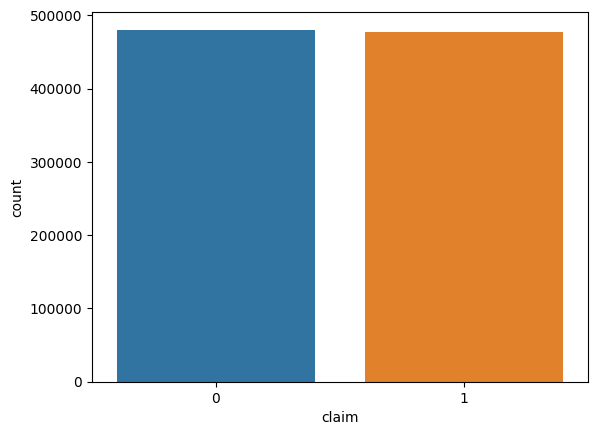

In [72]:
sns.countplot(data = train_df,x = "claim")

## **Duplicate**

In [73]:
features = train_df.columns.values[1:119]
dup_train = []
dup_test = []
for i in features:
    f = train_df[i].value_counts()
    dup_train.append([i,f.max(),f.idxmax()])
    f = test_df[i].value_counts()
    dup_test.append([i,f.max(),f.idxmax()])
dup_train = pd.DataFrame(dup_train,columns=["feature","max_dup","value"]).sort_values(by = 'max_dup',ascending = False)
dup_test = pd.DataFrame(dup_test,columns=["feature","max_dup","value"]).sort_values(by = 'max_dup',ascending = False)

# **Data Cleansing**

In [74]:
train_df = train_df.fillna(train_df.median())
test_df = test_df.fillna(test_df.median())

# **Data Analysis**

## **Raw Data**

In [75]:
def plot_feature_distribution(df1,df2,label1,label2,features):
    i = 0
    plt.figure()
    fig,ax = plt.subplots(12,10,figsize = (22,22))
    for feature in features:
        i += 1
        plt.subplot(12,10,i)
        sns.kdeplot(df1[feature],label = label1)
        sns.kdeplot(df2[feature],label = label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
        plt.legend()
    plt.show()

<Figure size 640x480 with 0 Axes>

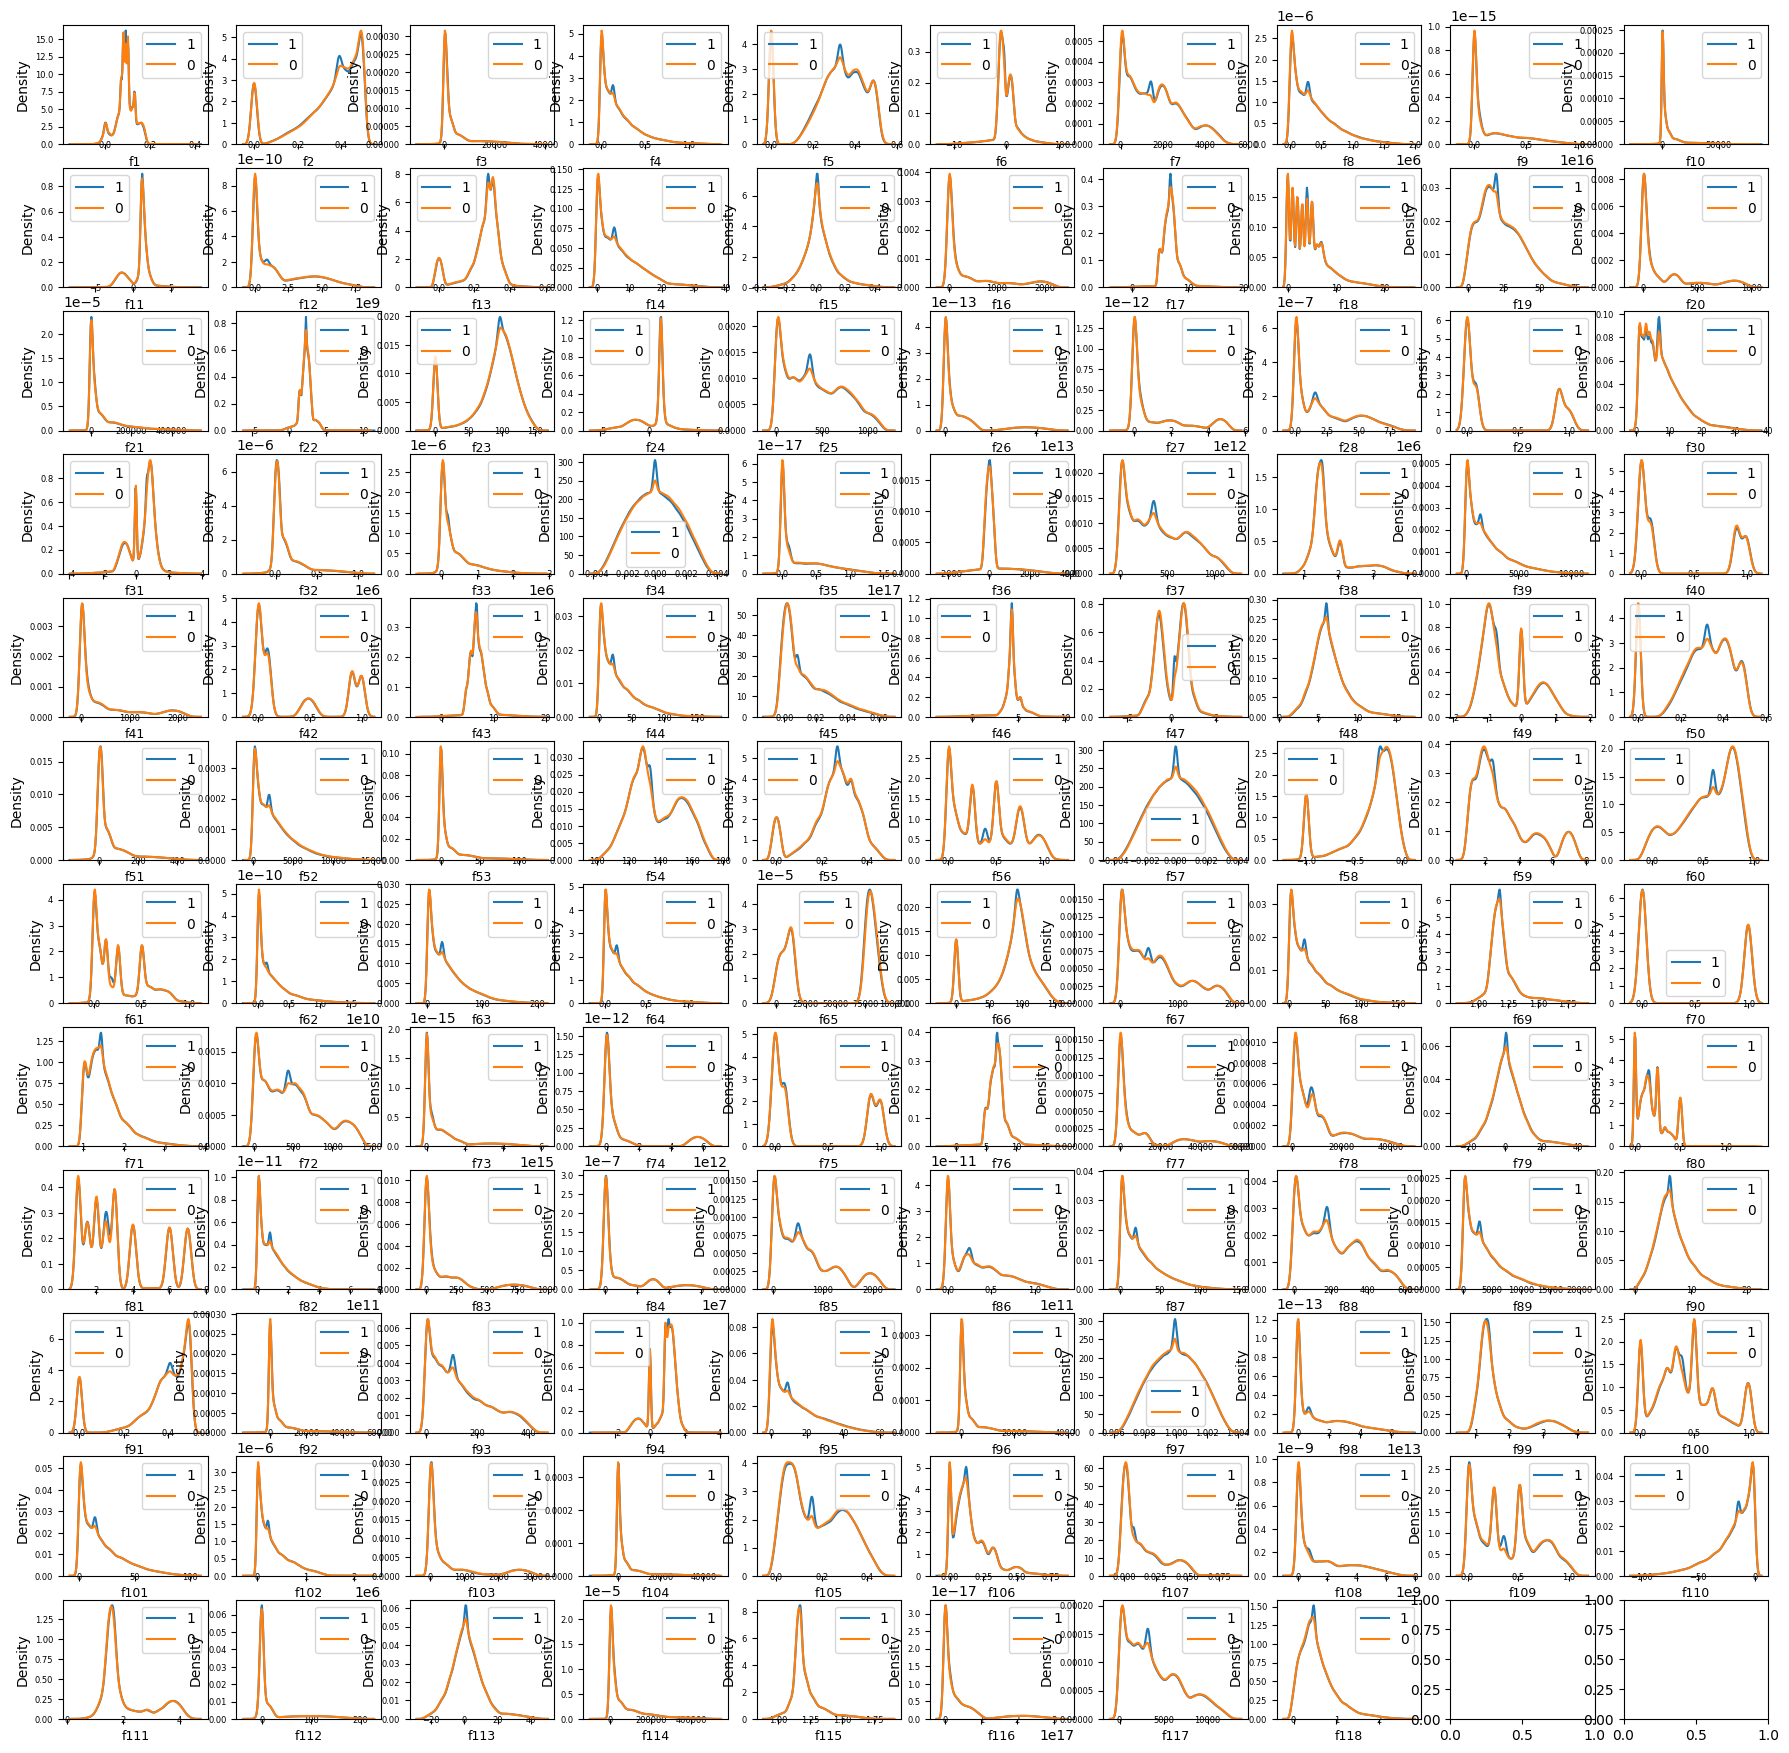

In [76]:
c1 = train_df.loc[train_df['claim'] == 1]
c0 = train_df.loc[train_df['claim'] == 0]
features = train_df.columns.values[1:119]
plot_feature_distribution(c1, c0, '1', '0', features)

<Figure size 640x480 with 0 Axes>

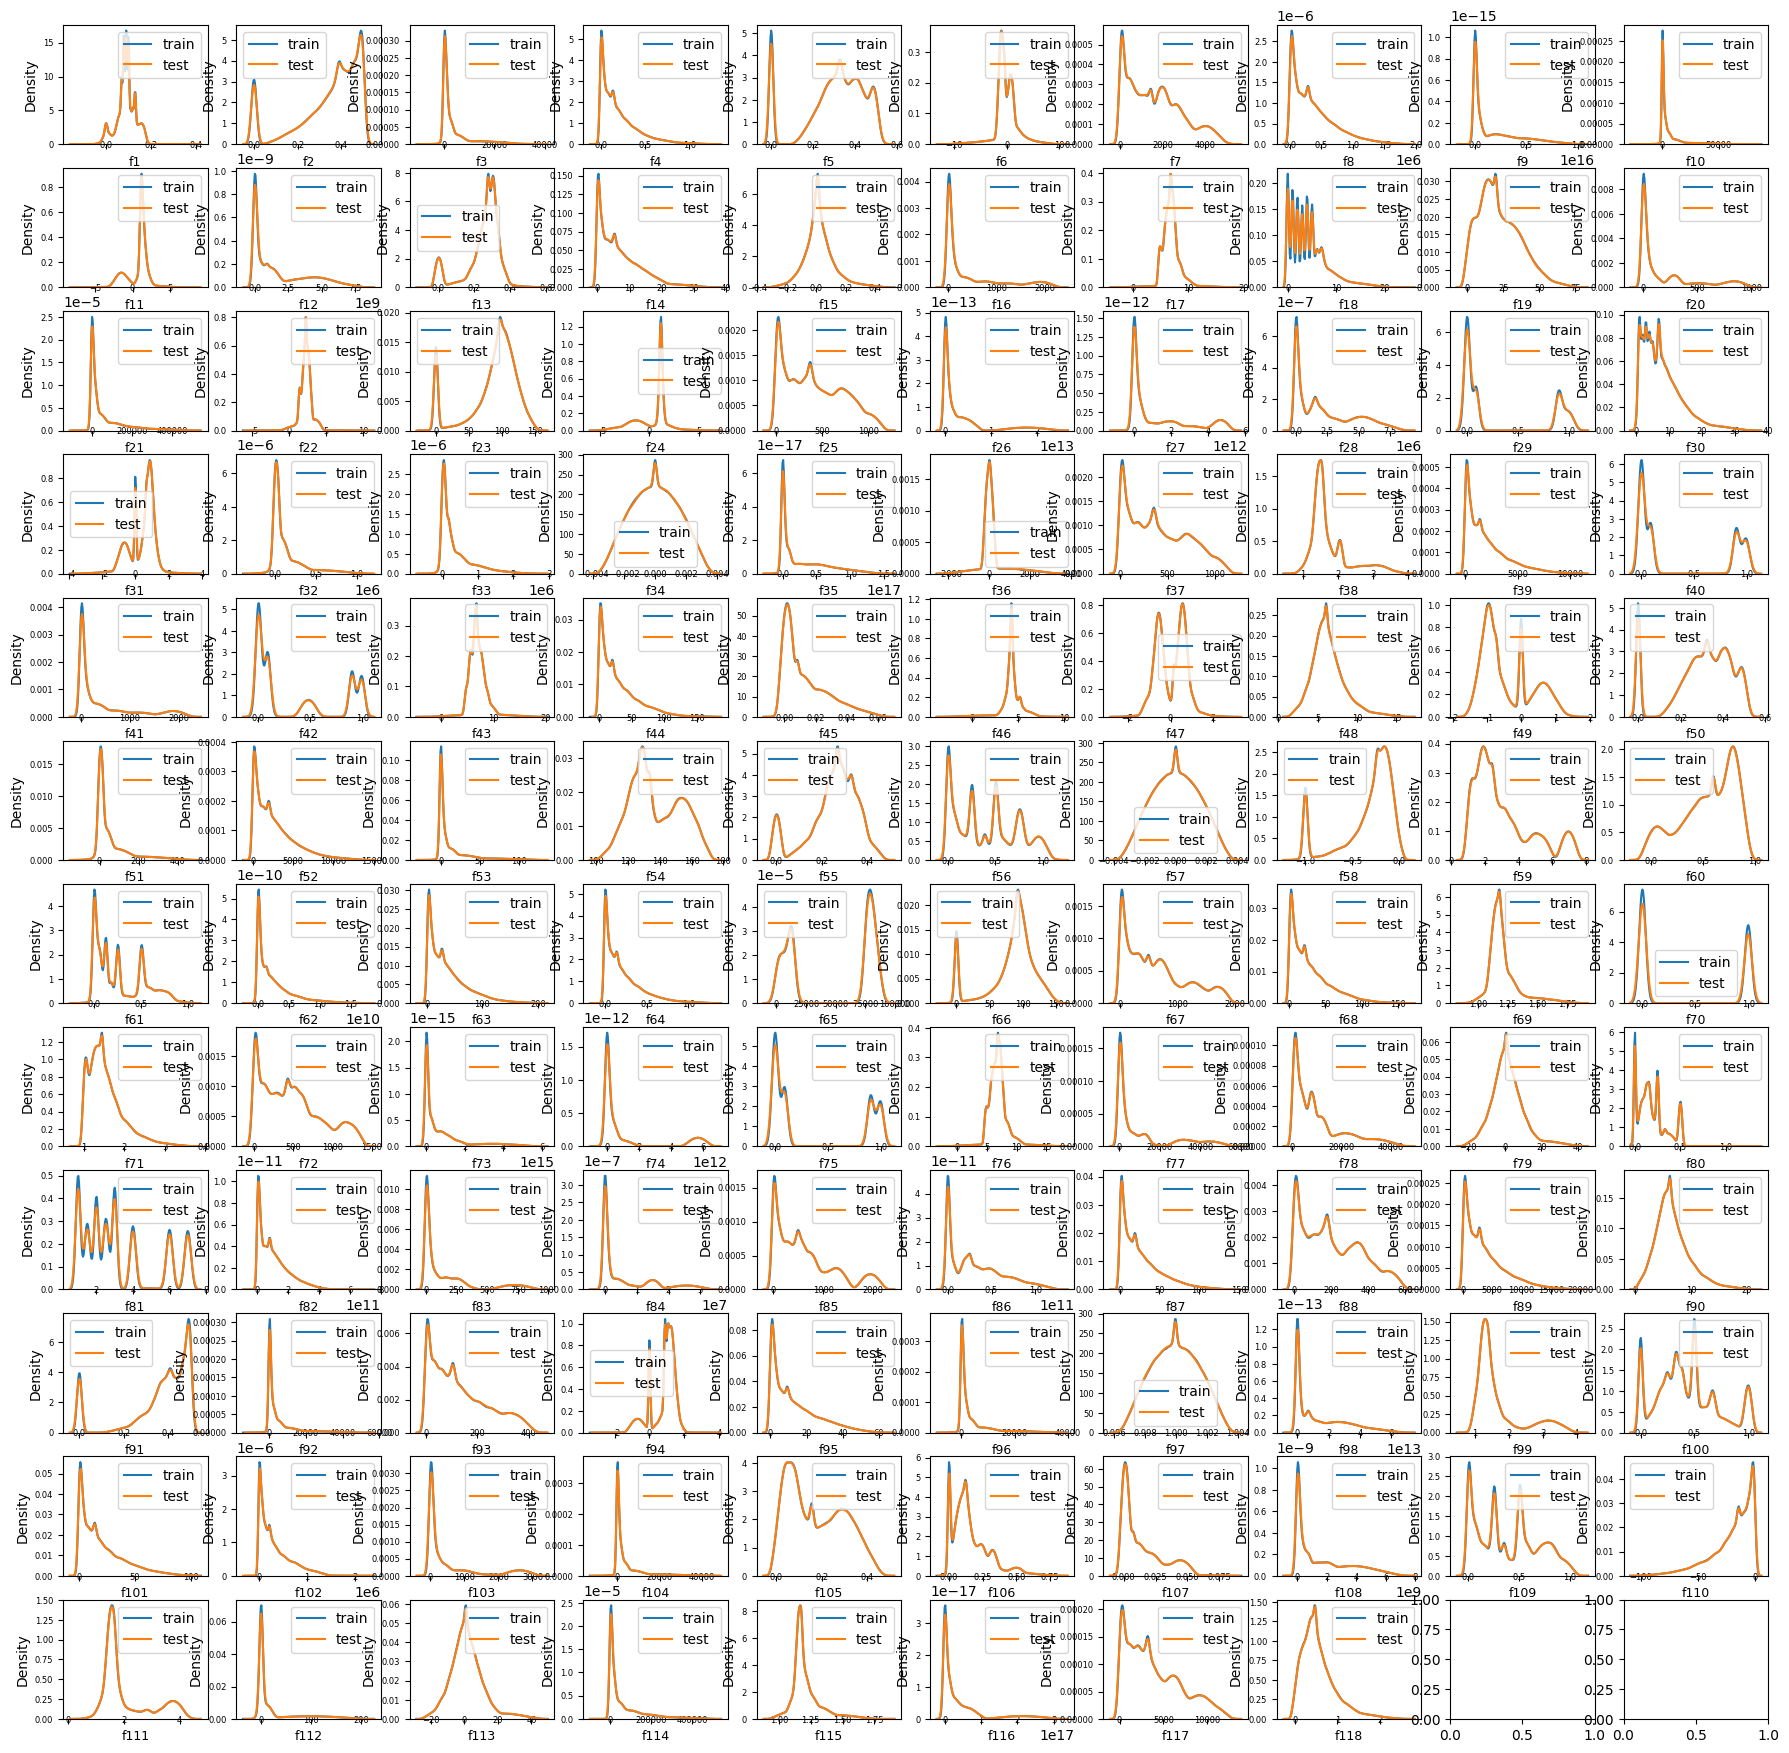

In [77]:
plot_feature_distribution(train_df,test_df,"train","test",features)

## **Mean**

<Figure size 640x480 with 0 Axes>

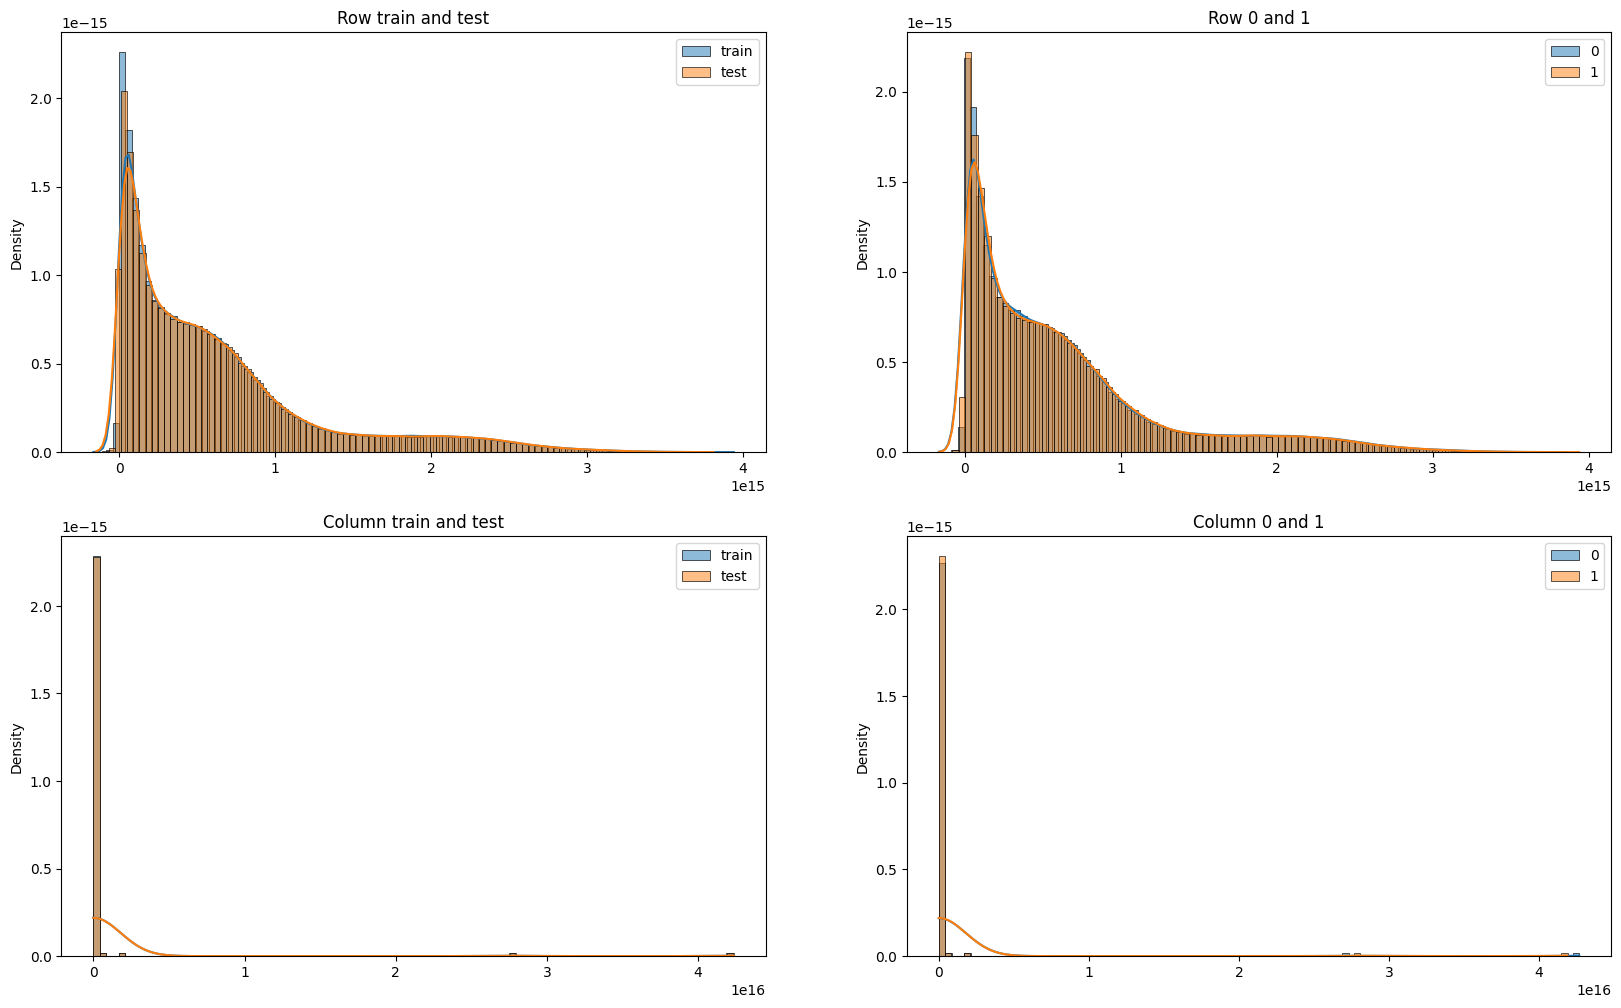

In [78]:
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(20,12))
features = train_df.columns.values[1:119]

plt.subplot(2,2,1)
plt.title("Row train and test")
sns.histplot(data = train_df[features].mean(axis = 1),kde = True,bins = 100, stat = "density",label = "train")
sns.histplot(data = test_df[features].mean(axis = 1),kde = True,bins = 100, stat = "density",label = "test")
plt.legend()

plt.subplot(2,2,2)
plt.title("Row 0 and 1")
sns.histplot(data = c0[features].mean(axis = 1),kde = True,bins = 100, stat = "density",label = "0")
sns.histplot(data = c1[features].mean(axis = 1),kde = True,bins = 100, stat = "density",label = "1")
plt.legend()

plt.subplot(2,2,3)
plt.title("Column train and test")
sns.histplot(data = train_df[features].mean(axis = 0),kde = True,bins = 100, stat = "density",label = "train")
sns.histplot(data = test_df[features].mean(axis = 0),kde = True,bins = 100, stat = "density",label = "test")
plt.legend()

plt.subplot(2,2,4)
plt.title("Column 0 and 1")
sns.histplot(data = c0[features].mean(axis = 0),kde = True,bins = 100, stat = "density",label = "0")
sns.histplot(data = c1[features].mean(axis = 0),kde = True,bins = 100, stat = "density",label = "1")
plt.legend()

<function matplotlib.pyplot.show(close=None, block=None)>

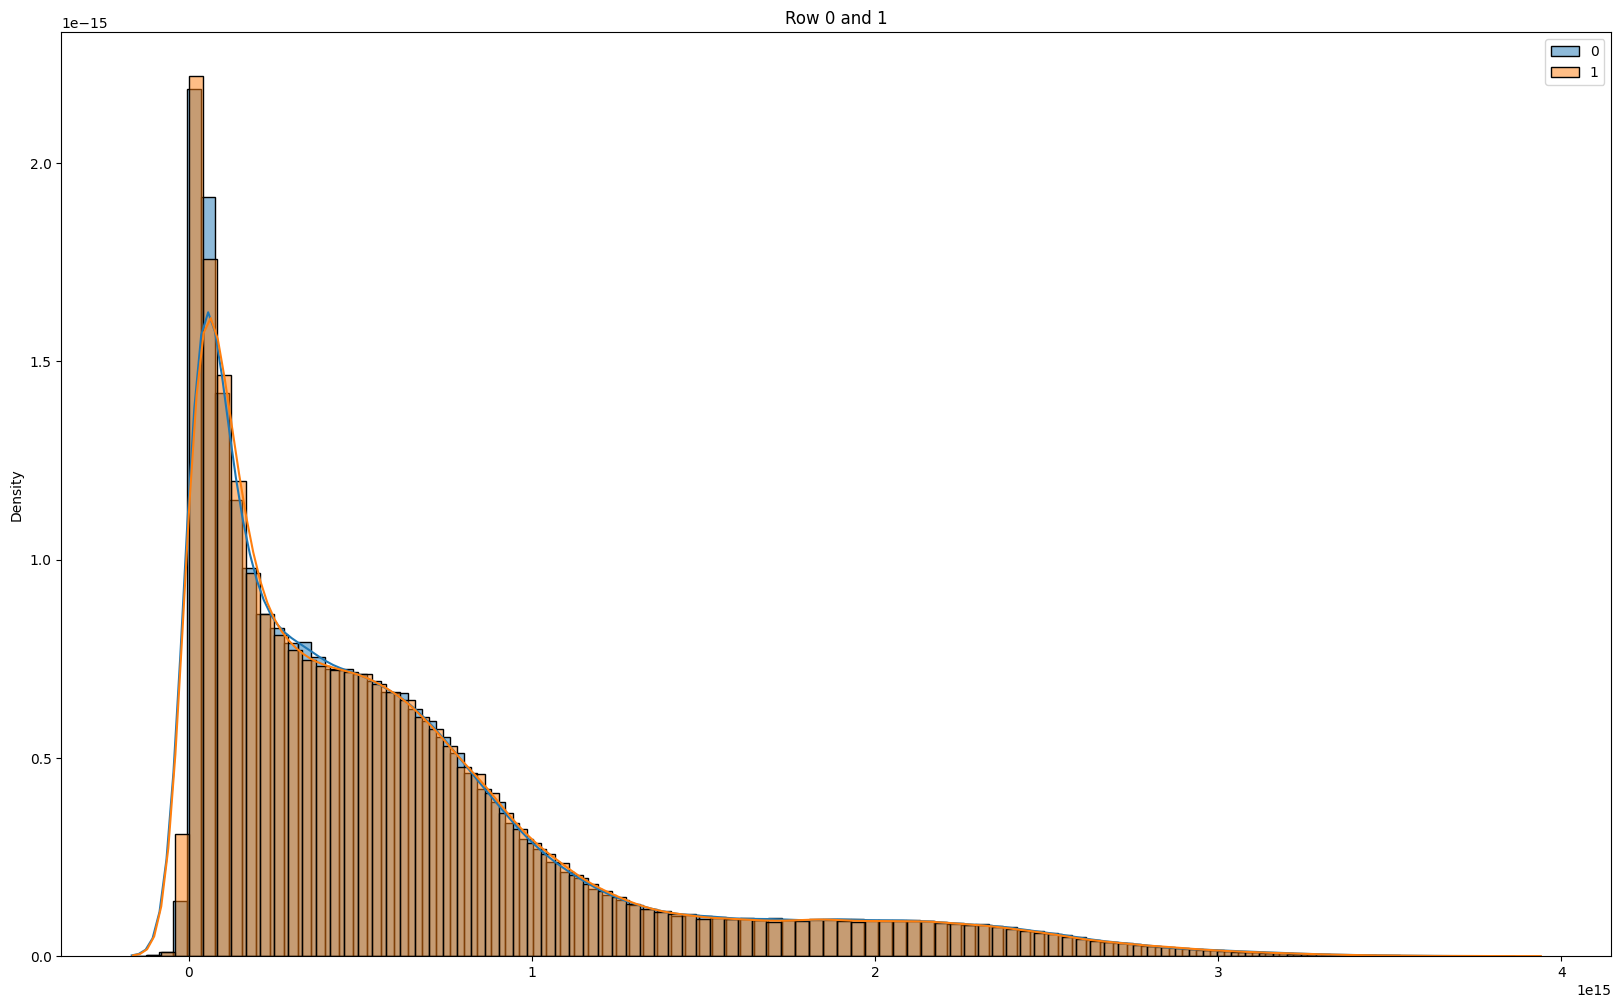

In [79]:
plt.figure(figsize = (20,12))
plt.title("Row 0 and 1")
sns.histplot(data = c0[features].mean(axis = 1),kde = True,bins = 100, stat = "density",label = "0")
sns.histplot(data = c1[features].mean(axis = 1),kde = True,bins = 100, stat = "density",label = "1")
plt.legend()
plt.show

## **Standard deviation**

<Figure size 640x480 with 0 Axes>

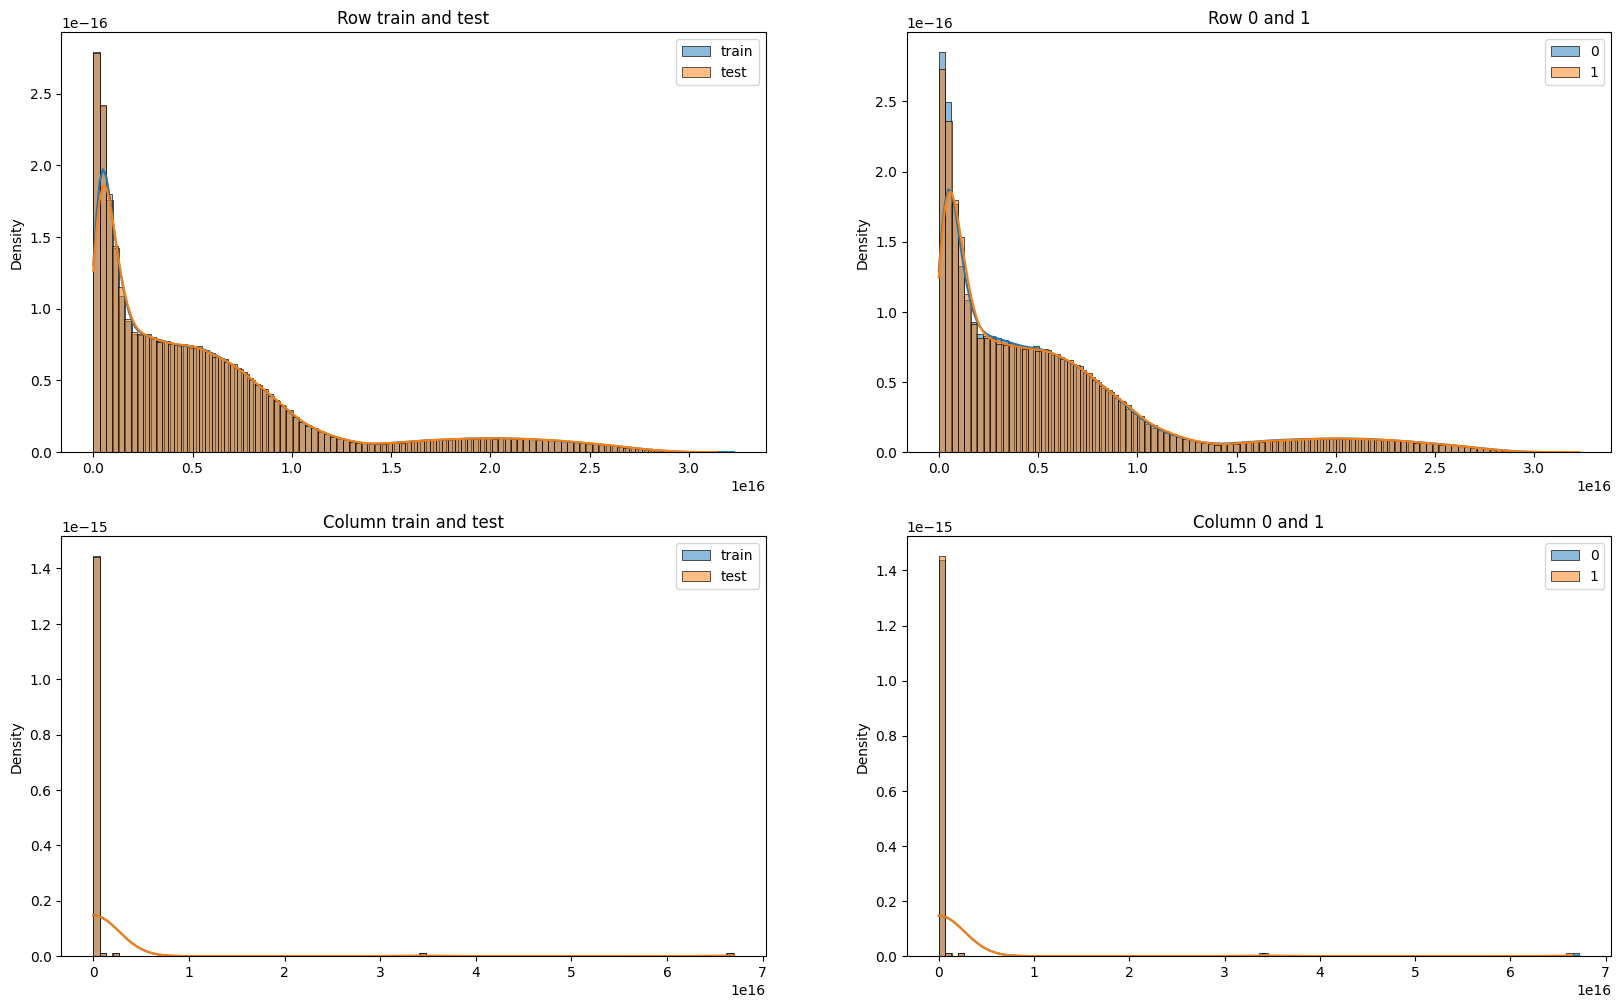

In [80]:
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(20,12))
features = train_df.columns.values[1:119]

plt.subplot(2,2,1)
plt.title("Row train and test")
sns.histplot(data = train_df[features].std(axis = 1),kde = True,bins = 100, stat = "density",label = "train")
sns.histplot(data = test_df[features].std(axis = 1),kde = True,bins = 100, stat = "density",label = "test")
plt.legend()

plt.subplot(2,2,2)
plt.title("Row 0 and 1")
sns.histplot(data = c0[features].std(axis = 1),kde = True,bins = 100, stat = "density",label = "0")
sns.histplot(data = c1[features].std(axis = 1),kde = True,bins = 100, stat = "density",label = "1")
plt.legend()

plt.subplot(2,2,3)
plt.title("Column train and test")
sns.histplot(data = train_df[features].std(axis = 0),kde = True,bins = 100, stat = "density",label = "train")
sns.histplot(data = test_df[features].std(axis = 0),kde = True,bins = 100, stat = "density",label = "test")
plt.legend()

plt.subplot(2,2,4)
plt.title("Column 0 and 1")
sns.histplot(data = c0[features].std(axis = 0),kde = True,bins = 100, stat = "density",label = "0")
sns.histplot(data = c1[features].std(axis = 0),kde = True,bins = 100, stat = "density",label = "1")
plt.legend()

<function matplotlib.pyplot.show(close=None, block=None)>

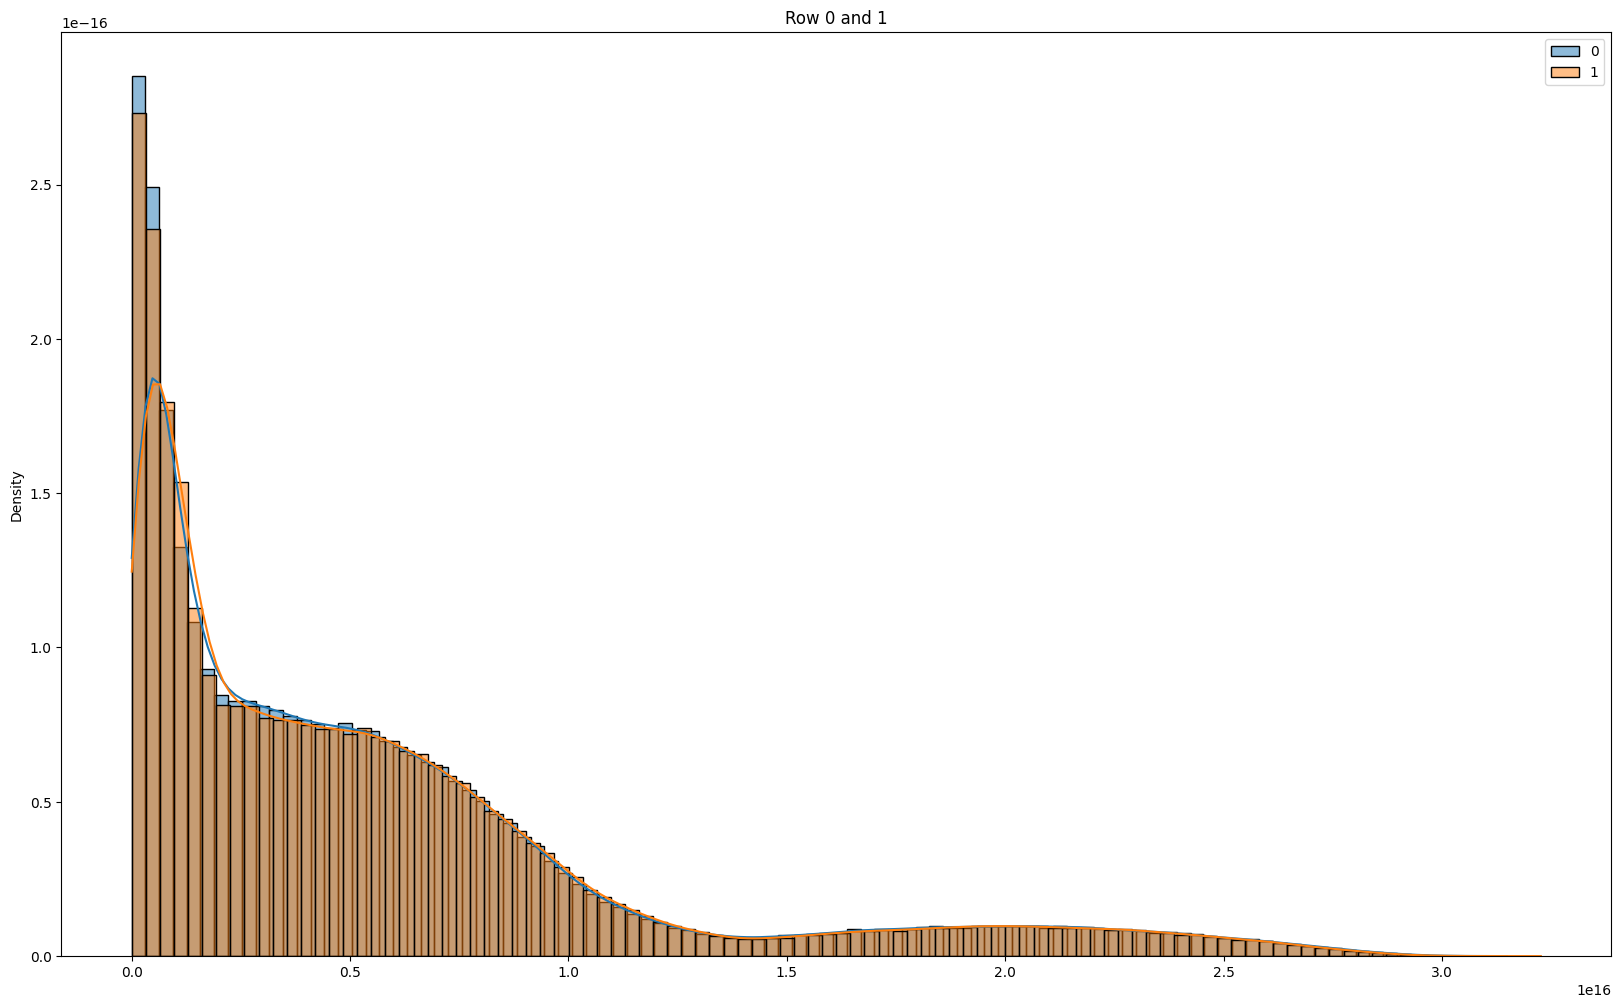

In [81]:
plt.figure(figsize = (20,12))
plt.title("Row 0 and 1")
sns.histplot(data = c0[features].std(axis = 1),kde = True,bins = 100, stat = "density",label = "0")
sns.histplot(data = c1[features].std(axis = 1),kde = True,bins = 100, stat = "density",label = "1")
plt.legend()
plt.show

## **Min**

<Figure size 640x480 with 0 Axes>

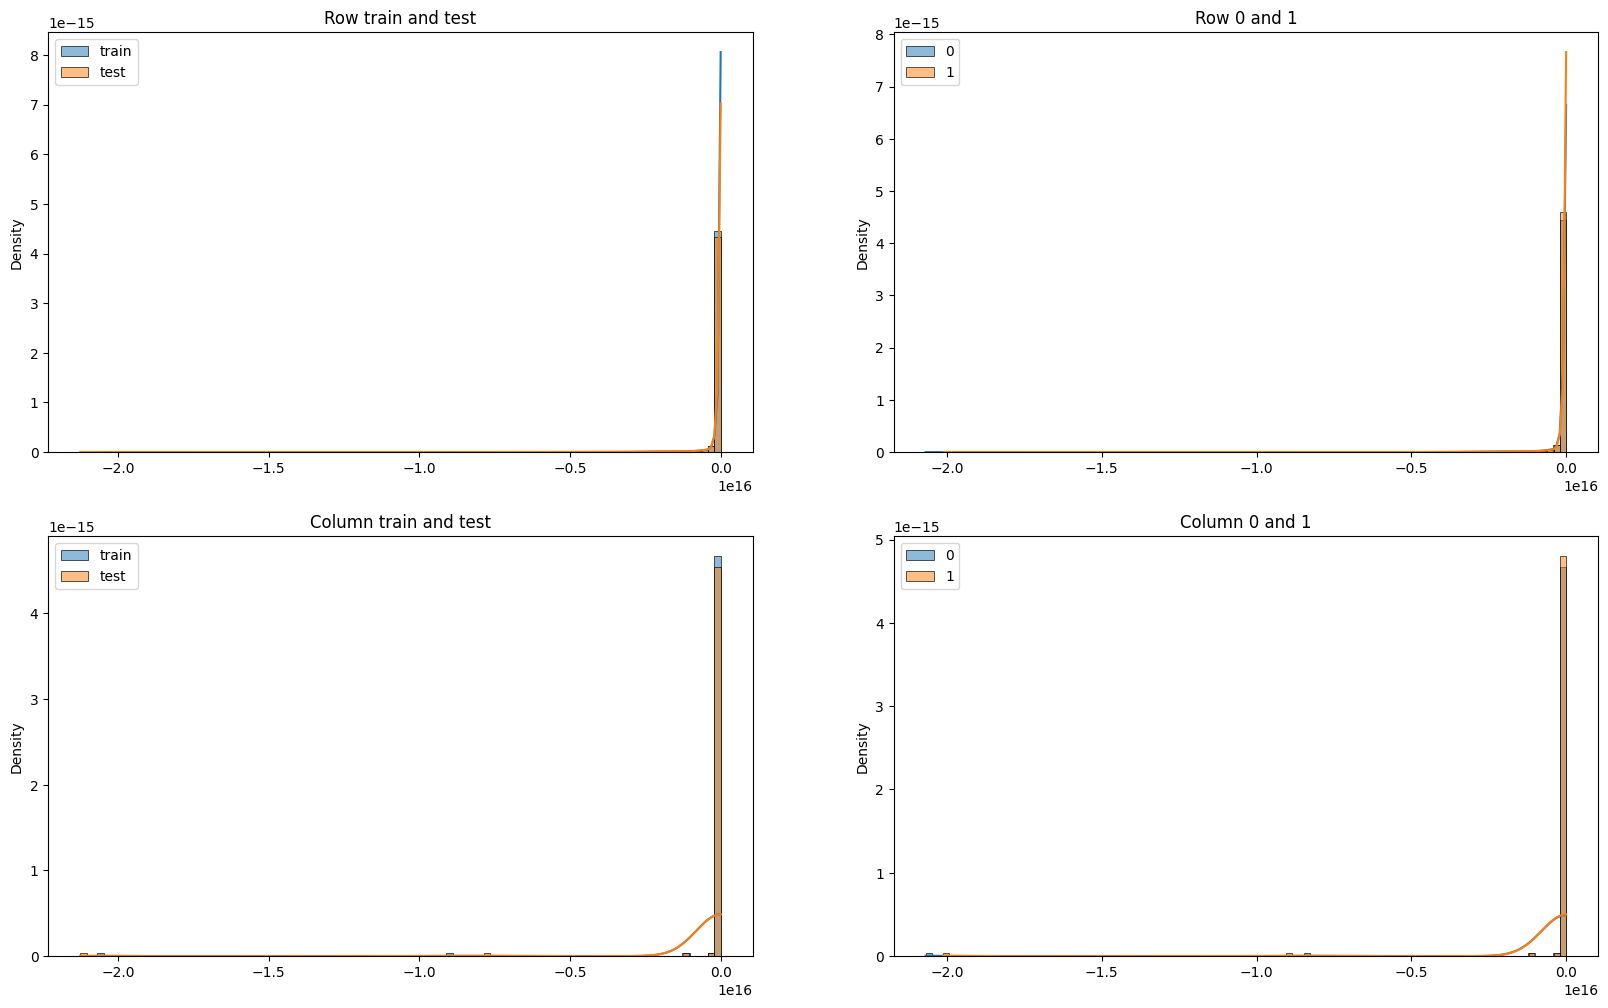

In [82]:
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(20,12))
features = train_df.columns.values[1:119]

plt.subplot(2,2,1)
plt.title("Row train and test")
sns.histplot(data = train_df[features].min(axis = 1),kde = True,bins = 100, stat = "density",label = "train")
sns.histplot(data = test_df[features].min(axis = 1),kde = True,bins = 100, stat = "density",label = "test")
plt.legend()

plt.subplot(2,2,2)
plt.title("Row 0 and 1")
sns.histplot(data = c0[features].min(axis = 1),kde = True,bins = 100, stat = "density",label = "0")
sns.histplot(data = c1[features].min(axis = 1),kde = True,bins = 100, stat = "density",label = "1")
plt.legend()

plt.subplot(2,2,3)
plt.title("Column train and test")
sns.histplot(data = train_df[features].min(axis = 0),kde = True,bins = 100, stat = "density",label = "train")
sns.histplot(data = test_df[features].min(axis = 0),kde = True,bins = 100, stat = "density",label = "test")
plt.legend()

plt.subplot(2,2,4)
plt.title("Column 0 and 1")
sns.histplot(data = c0[features].min(axis = 0),kde = True,bins = 100, stat = "density",label = "0")
sns.histplot(data = c1[features].min(axis = 0),kde = True,bins = 100, stat = "density",label = "1")
plt.legend()

## **Max**

<Figure size 640x480 with 0 Axes>

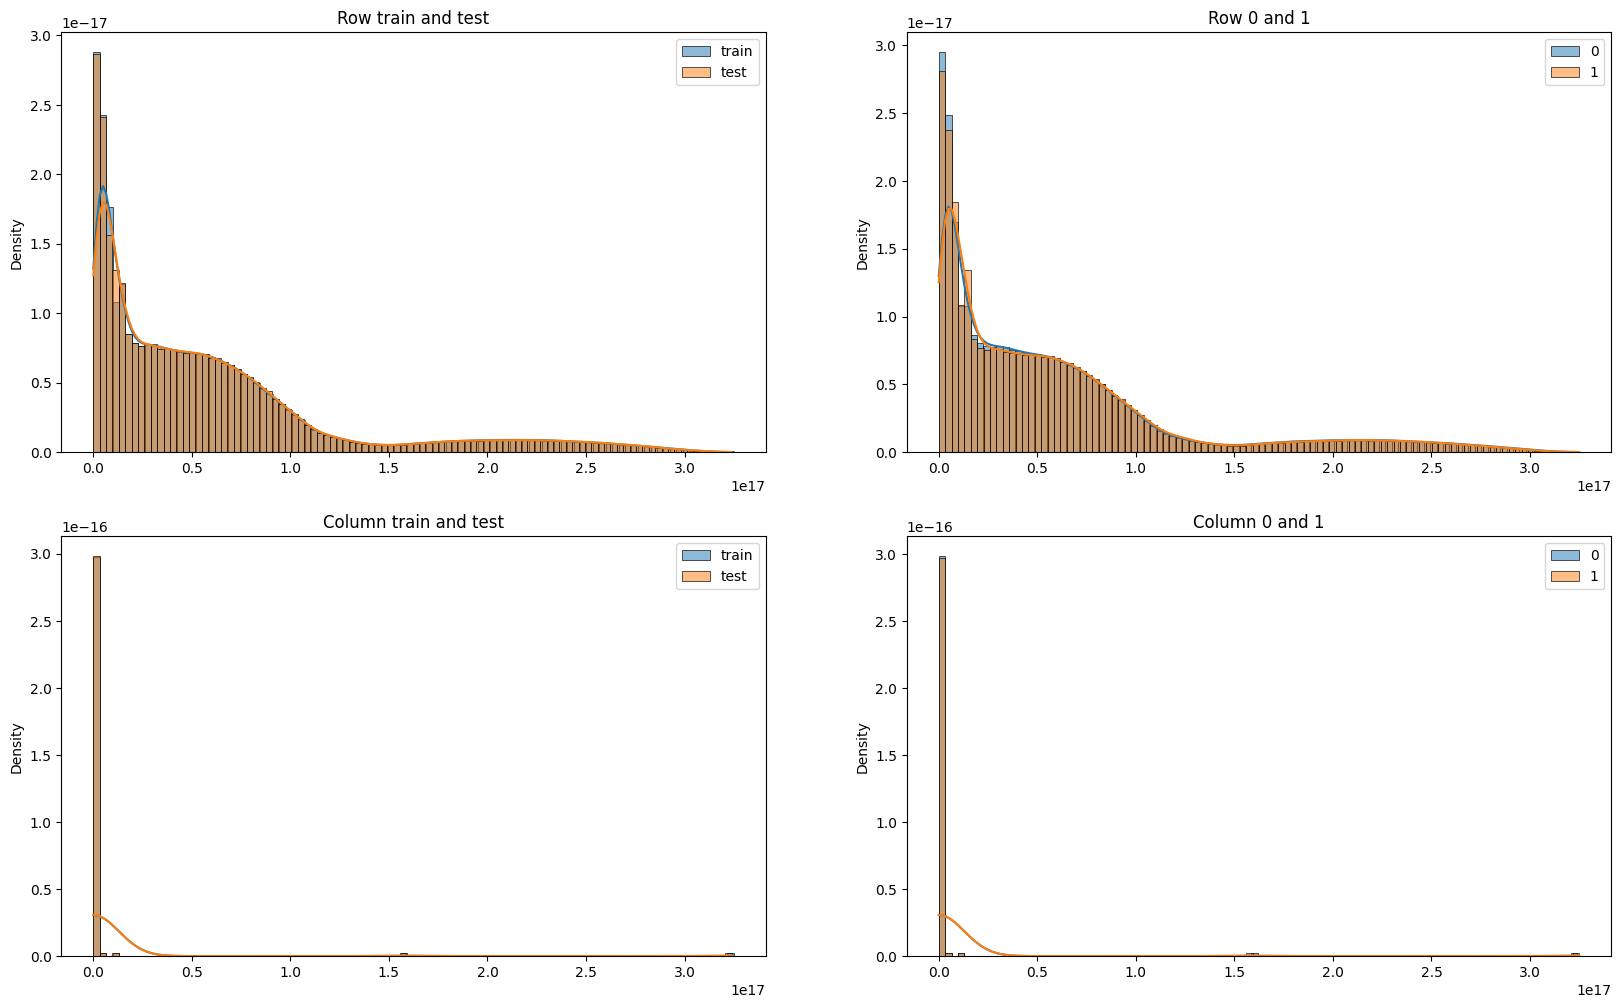

In [83]:
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(20,12))
features = train_df.columns.values[1:119]

plt.subplot(2,2,1)
plt.title("Row train and test")
sns.histplot(data = train_df[features].max(axis = 1),kde = True,bins = 100, stat = "density",label = "train")
sns.histplot(data = test_df[features].max(axis = 1),kde = True,bins = 100, stat = "density",label = "test")
plt.legend()

plt.subplot(2,2,2)
plt.title("Row 0 and 1")
sns.histplot(data = c0[features].max(axis = 1),kde = True,bins = 100, stat = "density",label = "0")
sns.histplot(data = c1[features].max(axis = 1),kde = True,bins = 100, stat = "density",label = "1")
plt.legend()

plt.subplot(2,2,3)
plt.title("Column train and test")
sns.histplot(data = train_df[features].max(axis = 0),kde = True,bins = 100, stat = "density",label = "train")
sns.histplot(data = test_df[features].max(axis = 0),kde = True,bins = 100, stat = "density",label = "test")
plt.legend()

plt.subplot(2,2,4)
plt.title("Column 0 and 1")
sns.histplot(data = c0[features].max(axis = 0),kde = True,bins = 100, stat = "density",label = "0")
sns.histplot(data = c1[features].max(axis = 0),kde = True,bins = 100, stat = "density",label = "1")
plt.legend()

## **Skew**

<Figure size 640x480 with 0 Axes>

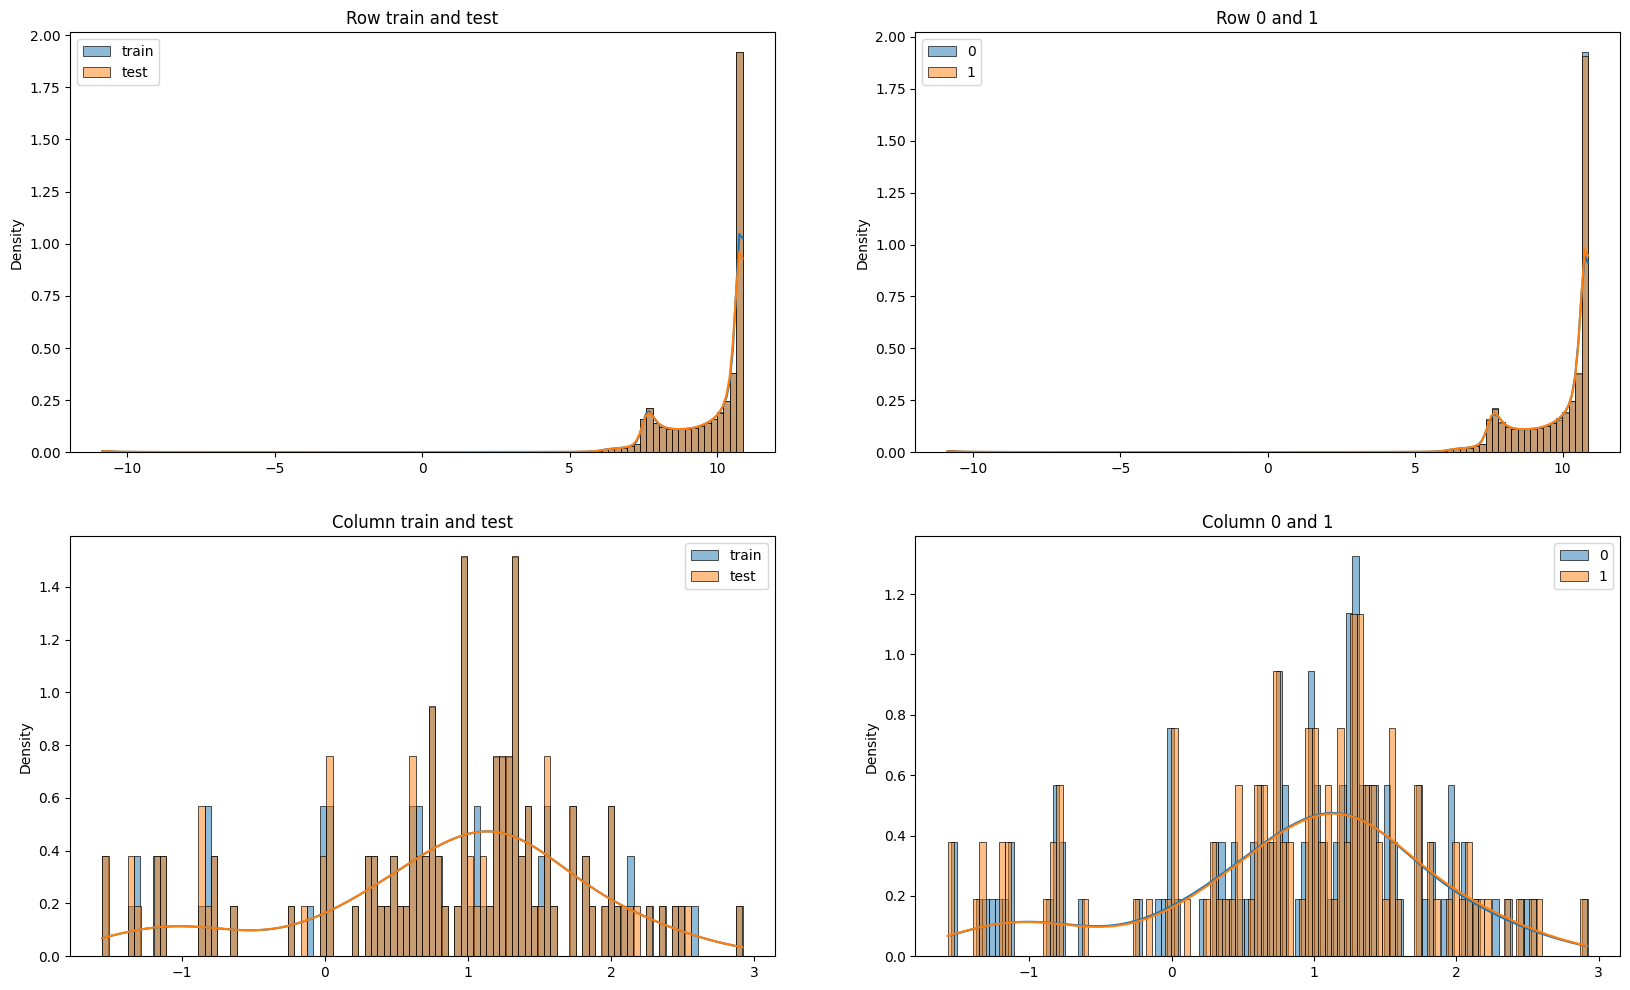

In [84]:
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(20,12))
features = train_df.columns.values[1:119]

plt.subplot(2,2,1)
plt.title("Row train and test")
sns.histplot(data = train_df[features].skew(axis = 1),kde = True,bins = 100, stat = "density",label = "train")
sns.histplot(data = test_df[features].skew(axis = 1),kde = True,bins = 100, stat = "density",label = "test")
plt.legend()

plt.subplot(2,2,2)
plt.title("Row 0 and 1")
sns.histplot(data = c0[features].skew(axis = 1),kde = True,bins = 100, stat = "density",label = "0")
sns.histplot(data = c1[features].skew(axis = 1),kde = True,bins = 100, stat = "density",label = "1")
plt.legend()

plt.subplot(2,2,3)
plt.title("Column train and test")
sns.histplot(data = train_df[features].skew(axis = 0),kde = True,bins = 100, stat = "density",label = "train")
sns.histplot(data = test_df[features].skew(axis = 0),kde = True,bins = 100, stat = "density",label = "test")
plt.legend()

plt.subplot(2,2,4)
plt.title("Column 0 and 1")
sns.histplot(data = c0[features].skew(axis = 0),kde = True,bins = 100, stat = "density",label = "0")
sns.histplot(data = c1[features].skew(axis = 0),kde = True,bins = 100, stat = "density",label = "1")
plt.legend()

<function matplotlib.pyplot.show(close=None, block=None)>

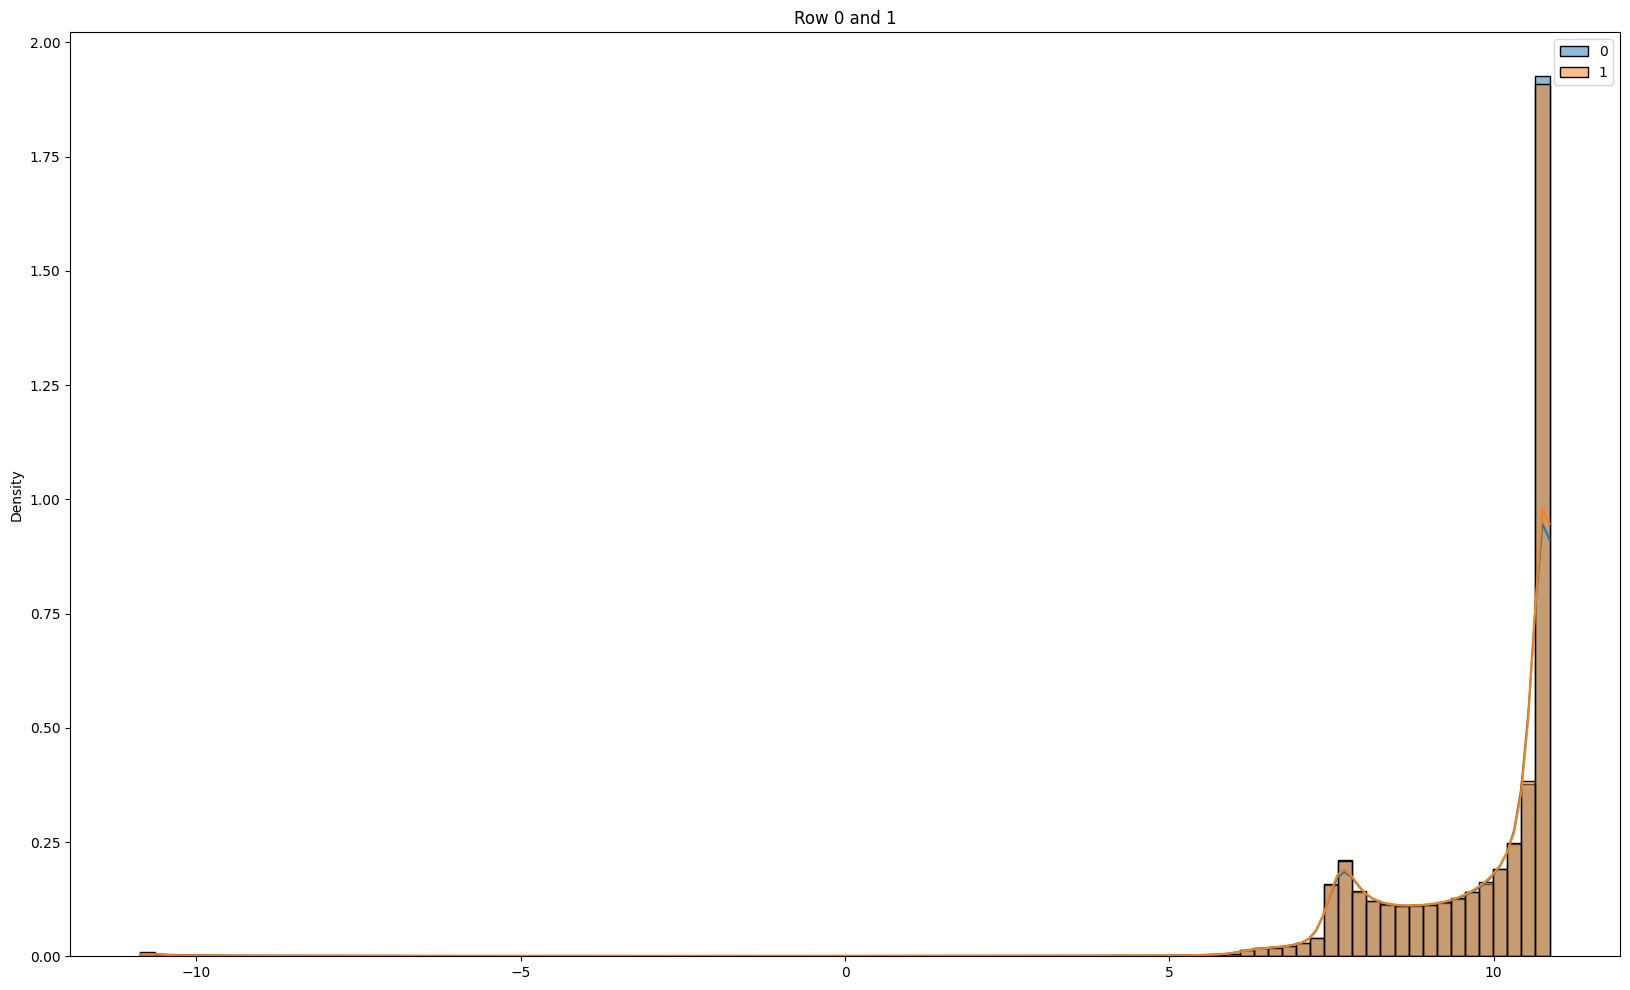

In [85]:
plt.figure(figsize = (20,12))
plt.title("Row 0 and 1")
sns.histplot(data = c0[features].skew(axis = 1),kde = True,bins = 100, stat = "density",label = "0")
sns.histplot(data = c1[features].skew(axis = 1),kde = True,bins = 100, stat = "density",label = "1")
plt.legend()
plt.show

## **Kurtosis**

<Figure size 640x480 with 0 Axes>

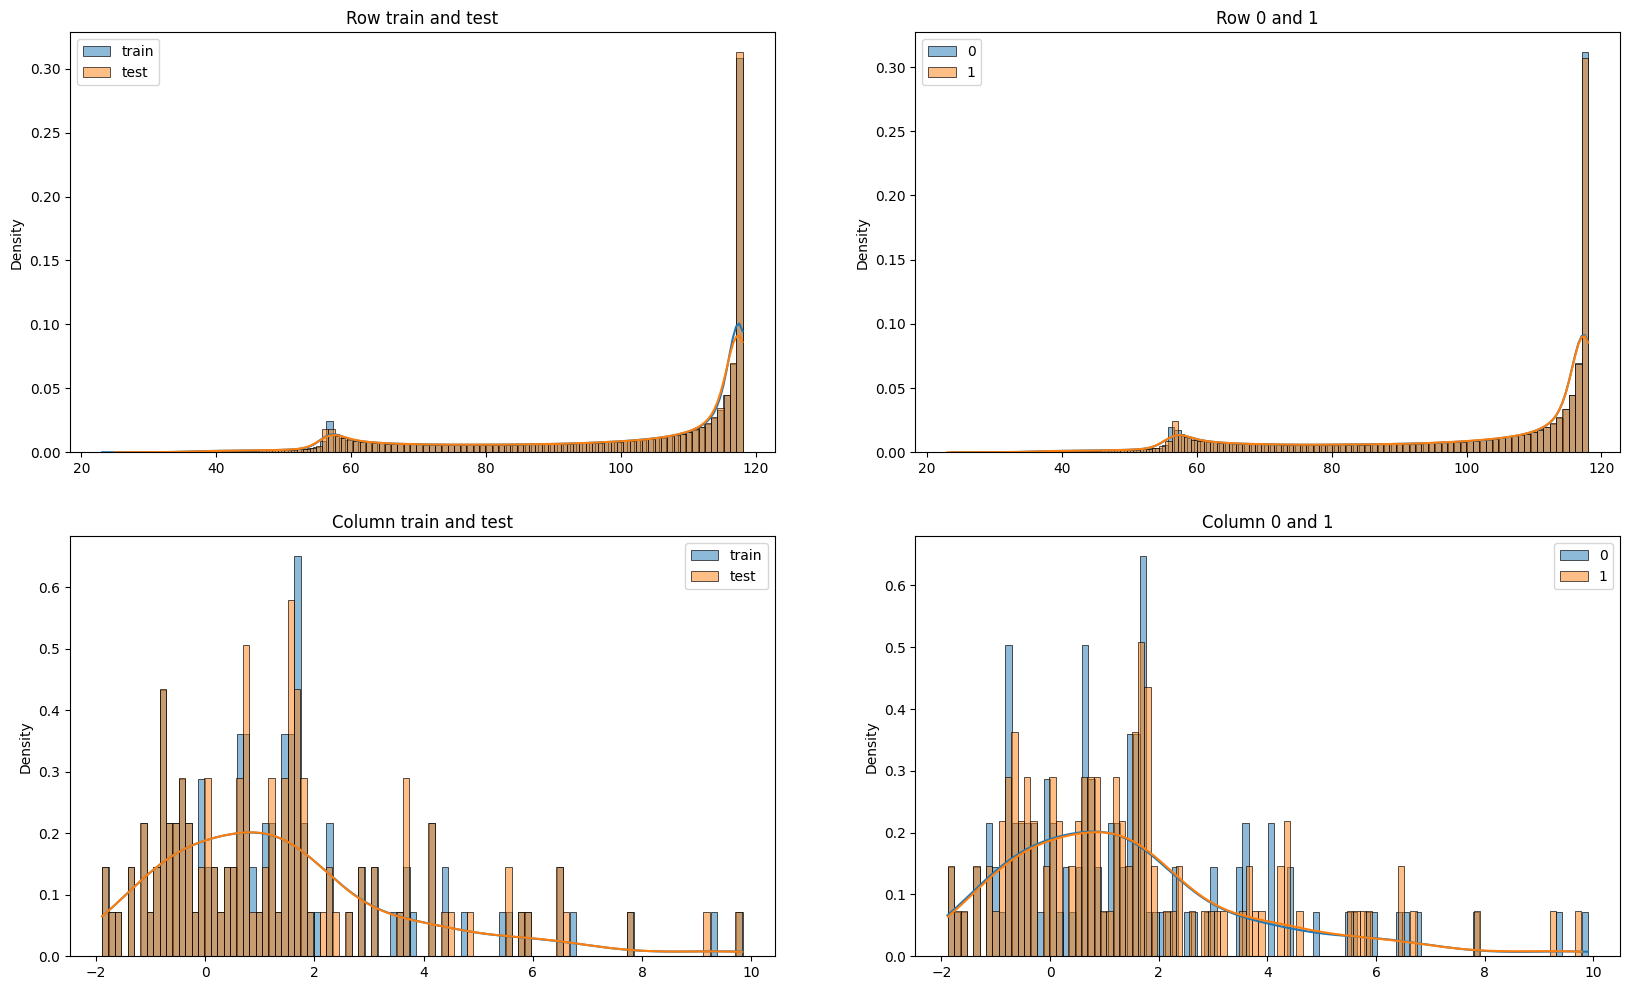

In [92]:
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(20,12))
features = train_df.columns.values[1:119]

plt.subplot(2,2,1)
plt.title("Row train and test")
sns.histplot(data = train_df[features].kurtosis(axis = 1),kde = True,bins = 100, stat = "density",label = "train")
sns.histplot(data = test_df[features].kurtosis(axis = 1),kde = True,bins = 100, stat = "density",label = "test")
plt.legend()

plt.subplot(2,2,2)
plt.title("Row 0 and 1")
sns.histplot(data = c0[features].kurtosis(axis = 1),kde = True,bins = 100, stat = "density",label = "0")
sns.histplot(data = c1[features].kurtosis(axis = 1),kde = True,bins = 100, stat = "density",label = "1")
plt.legend()

plt.subplot(2,2,3)
plt.title("Column train and test")
sns.histplot(data = train_df[features].kurtosis(axis = 0),kde = True,bins = 100, stat = "density",label = "train")
sns.histplot(data = test_df[features].kurtosis(axis = 0),kde = True,bins = 100, stat = "density",label = "test")
plt.legend()

plt.subplot(2,2,4)
plt.title("Column 0 and 1")
sns.histplot(data = c0[features].kurtosis(axis = 0),kde = True,bins = 100, stat = "density",label = "0")
sns.histplot(data = c1[features].kurtosis(axis = 0),kde = True,bins = 100, stat = "density",label = "1")
plt.legend()

## **Sum**

<Figure size 640x480 with 0 Axes>

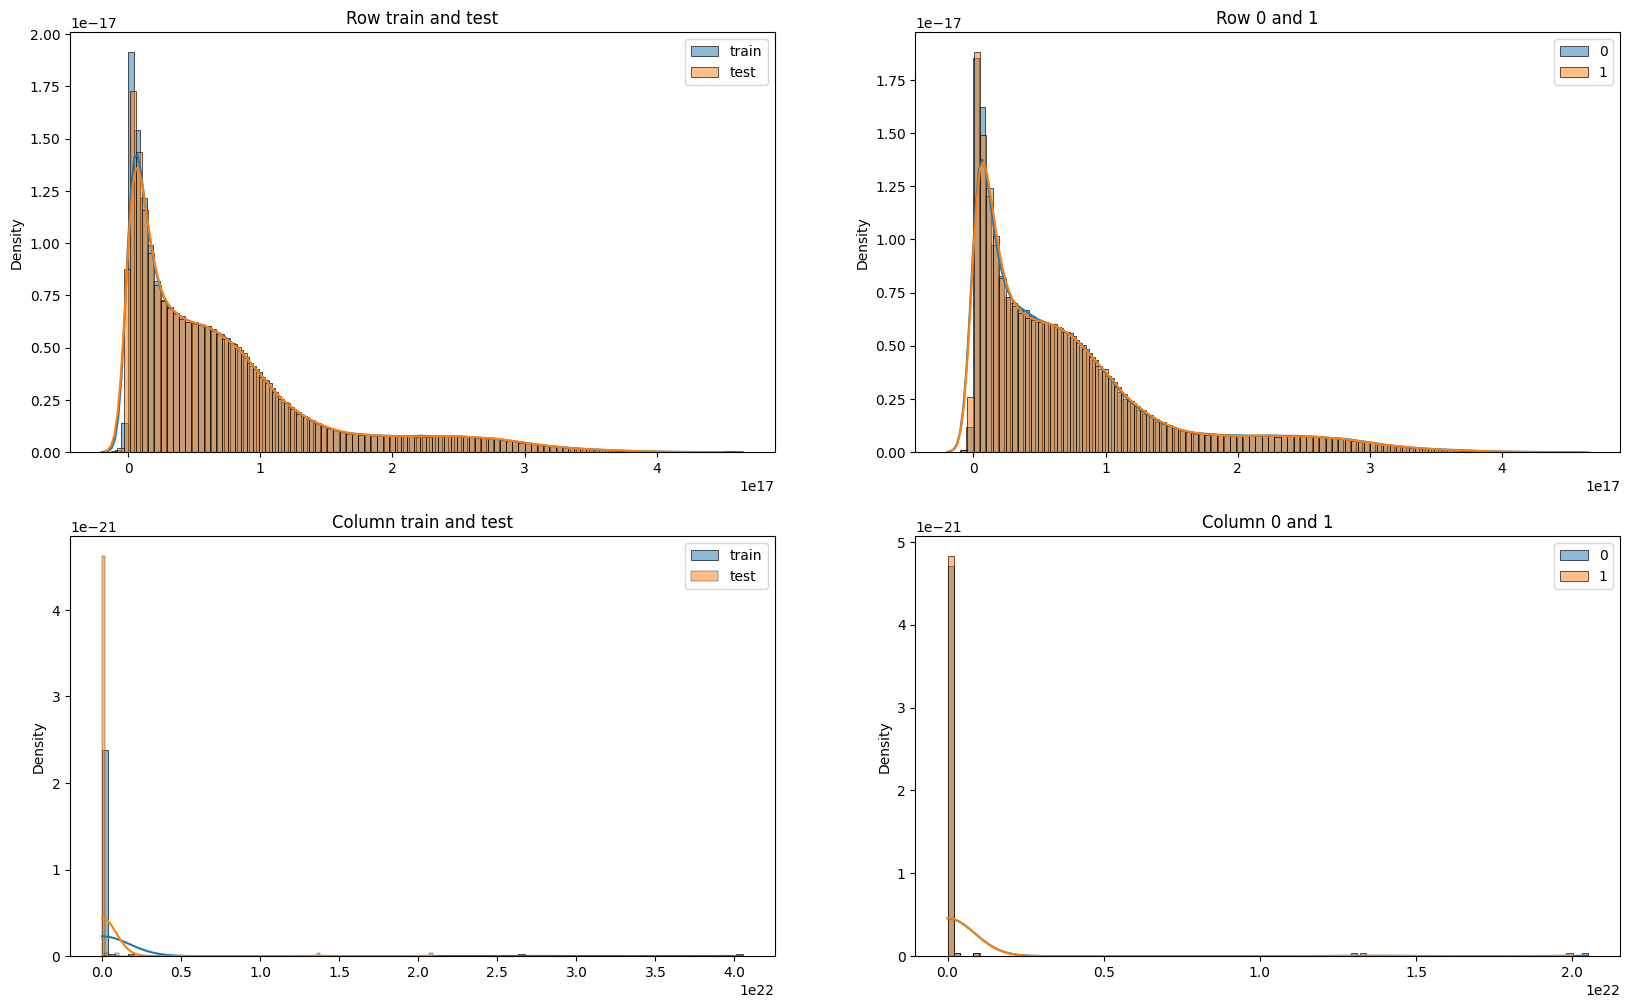

In [93]:
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(20,12))
features = train_df.columns.values[1:119]

plt.subplot(2,2,1)
plt.title("Row train and test")
sns.histplot(data = train_df[features].sum(axis = 1),kde = True,bins = 100, stat = "density",label = "train")
sns.histplot(data = test_df[features].sum(axis = 1),kde = True,bins = 100, stat = "density",label = "test")
plt.legend()

plt.subplot(2,2,2)
plt.title("Row 0 and 1")
sns.histplot(data = c0[features].sum(axis = 1),kde = True,bins = 100, stat = "density",label = "0")
sns.histplot(data = c1[features].sum(axis = 1),kde = True,bins = 100, stat = "density",label = "1")
plt.legend()

plt.subplot(2,2,3)
plt.title("Column train and test")
sns.histplot(data = train_df[features].sum(axis = 0),kde = True,bins = 100, stat = "density",label = "train")
sns.histplot(data = test_df[features].sum(axis = 0),kde = True,bins = 100, stat = "density",label = "test")
plt.legend()

plt.subplot(2,2,4)
plt.title("Column 0 and 1")
sns.histplot(data = c0[features].sum(axis = 0),kde = True,bins = 100, stat = "density",label = "0")
sns.histplot(data = c1[features].sum(axis = 0),kde = True,bins = 100, stat = "density",label = "1")
plt.legend()

## **Correlation**

In [87]:
corr = train_df.corr().abs().unstack().sort_values(kind="quicksort",ascending = False).reset_index()
corr = corr[corr['level_0'] != corr['level_1']]

In [88]:
corr.head(20)

,level_0,level_1,0
120,f97,f57,0.056387
121,f57,f97,0.056387
122,f45,f97,0.025849
123,f97,f45,0.025849
124,f51,f57,0.025067
125,f57,f51,0.025067
126,f32,f34,0.025054
127,f34,f32,0.025054
128,f15,f57,0.025016
129,f57,f15,0.025016


In [89]:
corr.tail(20)

,level_0,level_1,0
14380,f4,f46,6.149035e-06
14381,f46,f4,6.149035e-06
14382,f51,f112,5.391607e-06
14383,f112,f51,5.391607e-06
14384,f61,f55,4.821990e-06
14385,f55,f61,4.821990e-06
14386,f67,f105,4.112514e-06
14387,f105,f67,4.112514e-06
14388,f118,f53,4.066111e-06
14389,f53,f118,4.066111e-06


# **Feature Engineering**

In [94]:
features = train_df.columns.values[1:119]
for df in [train_df, test_df]:
    df['sum'] = df[features].sum(axis=1)
    df['mean'] = df[features].mean(axis=1)
    df['min'] = df[features].min(axis=1)
    df['max'] = df[features].max(axis=1)
    df['std'] = df[features].std(axis=1)
    df['kurt'] = df[features].kurtosis(axis=1)
    df['skew'] = df[features].skew(axis=1)

In [95]:
train_df.head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f117,f118,claim,sum,mean,min,max,std,kurt,skew
0,0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,...,140.1,1.01770,1,1.294749e+16,1.097245e+14,-3.756600e+01,1.090600e+16,1.008624e+15,115.030513,10.667874
1,1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,...,1861.0,0.28359,0,4.579784e+16,3.881173e+14,-5.675800e+01,3.079400e+16,2.945630e+15,99.411775,9.711352
2,2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,...,3838.2,0.40690,1,3.547953e+14,3.006739e+12,-4.453500e+13,3.218100e+14,3.039317e+13,105.987053,10.053020
3,3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,...,4889.1,0.51486,1,1.939931e+15,1.644009e+13,-9.299200e+13,1.894700e+15,1.748090e+14,116.832885,10.782331
4,4,0.11623,0.502900,-109.150,0.297910,0.34490,-0.40932,2538.90,65332.0,1.907200e+15,...,3228.0,0.23049,1,1.262859e+16,1.070219e+14,-8.991300e+12,1.012500e+16,9.479003e+14,109.281599,10.322508


# **Model**

In [101]:
features = [c for c in train_df.columns if c not in ['id', 'claim']]
target = train_df['claim']

In [102]:
label = 'claim' 
metric = 'roc_auc'  

predictor = TabularPredictor(label=label, eval_metric=metric).fit(
    train_data=train_df,
    presets='best_quality',
    time_limit=3600
)

No path specified. Models will be saved in: "AutogluonModels/ag-20260116_162612"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Sep 27 10:16:09 UTC 2025
CPU Count:          4
Pytorch Version:    2.6.0+cu124
CUDA Version:       12.4
GPU Memory:         GPU 0: 15.89/15.89 GB
Total GPU Memory:   Free: 15.89 GB, Allocated: 0.00 GB, Total: 15.89 GB
GPU Count:          1
Memory Avail:       24.23 GB / 31.35 GB (77.3%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True

# **Evaluation**

In [103]:
predictor.leaderboard(train_df, silent=True)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT_BAG_L2,0.763660,0.731953,roc_auc,331.961665,61.402628,2371.387168,93.614702,15.998077,698.545706,2,True,4
1,WeightedEnsemble_L3,0.763660,0.731953,roc_auc,331.968749,61.577717,2390.355158,0.007084,0.175088,18.967990,3,True,6
2,LightGBM_BAG_L2,0.745602,0.723064,roc_auc,248.060994,46.914526,1797.364443,9.714031,1.509974,124.522981,2,True,5
3,WeightedEnsemble_L2,0.732592,0.713087,roc_auc,238.357068,45.576569,1682.348442,0.010105,0.172017,9.506980,2,True,3
4,LightGBM_BAG_L1,0.727515,0.710957,roc_auc,31.272775,4.768001,257.989743,31.272775,4.768001,257.989743,1,True,2
5,LightGBMXT_BAG_L1,0.693699,0.650838,roc_auc,207.074189,40.636550,1414.851719,207.074189,40.636550,1414.851719,1,True,1


In [104]:
predictor.evaluate(train_df)

{'roc_auc': 0.7636602636991708,
 'accuracy': 0.7044144651061311,
 'balanced_accuracy': 0.7042841801298085,
 'mcc': 0.4101443105071116,
 'f1': 0.6903815515093991,
 'precision': 0.7223951229782054,
 'recall': 0.6610849920944892}

In [105]:
predictions = predictor.predict_proba(test_df)[1]

# **Submission**

In [106]:
submission = pd.DataFrame({
    'id': test_df['id'],
    'claim': predictions
})

In [107]:
submission.head()

,id,claim
0,957919,0.531775
1,957920,0.300672
2,957921,0.234006
3,957922,0.350940
4,957923,0.268791


In [108]:
submission.to_csv('submission.csv', index=False)